# Notebook gestion des données Rhone

### Import des library

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from coordonnee_rhone import groupe_riviere, create_point_distance
from coordonnee_rhone import find_nearest_river, find_nearest_river_distance, find_site, get_nearest_distance
from fontion_API import get_site_data

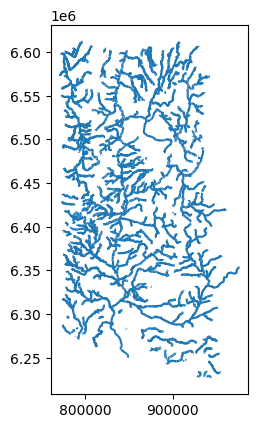

In [3]:
# Charger un fichier GeoJSON
rivers_gdf = gpd.read_file("database/donnee_rhone_affluent.geojson")
if rivers_gdf.crs.to_string() != "EPSG:2154":
    rivers_gdf = rivers_gdf.to_crs(epsg=2154)
rivers_gdf.plot()
plt.show()

### On garde que les affluents importants

In [28]:
rivers_gdf.loc[rivers_gdf['name'] == "L'Aygues", 'name'] = "L'Eygues"
rivers_gdf.loc[rivers_gdf['name'] == "Canal de Miribel", 'name'] = "Le Rhône"
rivers_gdf.loc[rivers_gdf['name'] == "Le Gardon d'Alès", 'name'] = "Le Gardon"
affluent = ["L'Ain", 'La Saône', "L'Isère", "L'Eyrieux", "La Drôme", "L'Ardèche", 'La Cèze', "Le Rhône", "L'Eygues", "Canal de Miribel","L'Ouvèze", "La Durance", "Le Gardon"]
# 'Le Rhône - Bras Mort de la Barthelasse', 'Le Petit Rhône', 'Le Rhône - Canal de Beaucaire']
affluent_river = rivers_gdf[rivers_gdf['name'].isin(affluent)]

In [29]:
affluent_river_groupe = groupe_riviere(affluent_river)
point_distance = create_point_distance(affluent_river_groupe, 1)


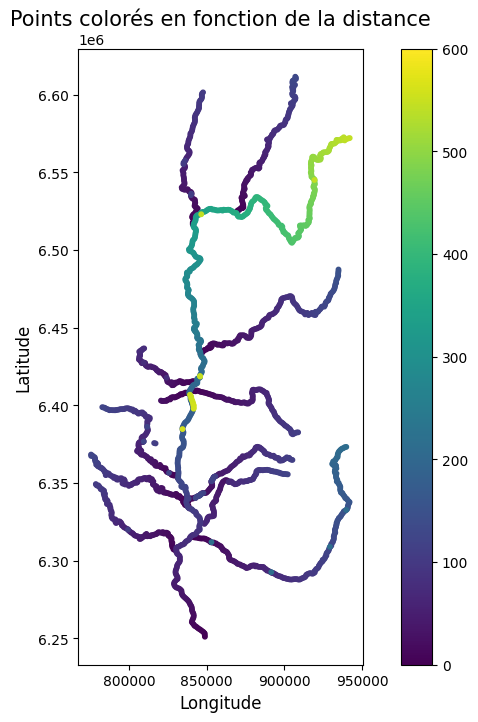

In [30]:
vmin, vmax = 0, 600
# garder que les element entre l'id a et l'id b
# Créer le plot
fig, ax = plt.subplots(figsize=(10, 8))
point_distance.plot(
    column='distance',          # Colonne à utiliser pour la couleur
    cmap='viridis',             # Palette de couleurs (modifiable selon vos préférences)
    legend=True,                # Afficher la légende
    vmin=vmin,                  # Minimum de l'échelle de couleur
    vmax=vmax,                  # Maximum de l'échelle de couleur
    ax=ax,                      # Axe de la figure
    markersize=10               # Taille des points (ajuster si nécessaire)
)
# Ajouter un titre et configurer l'affichage
ax.set_title("Points colorés en fonction de la distance", fontsize=15)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Afficher la carte
plt.show()


In [31]:
# Faire un dataframe avec pour chaque riviere son dernier point de point_distance et la riviere la plus proche de ce point
# trier les points par distance
point_distance = point_distance.sort_values('distance')
df_confluence = point_distance.groupby('riviere').first().reset_index()
df_confluence['riviere_proche'] = df_confluence.apply(lambda x: find_nearest_river(x, affluent_river_groupe), axis=1)
df_confluence['distance_rhone']= df_confluence.apply(lambda x: find_nearest_river_distance(x, point_distance), axis=1)
# sauvegarder en csv
df_confluence.to_csv('database/confluence.csv', index=False)
df_confluence


,riviere,distance,geometry,riviere_proche,distance_rhone
0,L'Ain,0.0,POINT (869105.893 6523853.843),Le Rhône,367.0
1,L'Ardèche,0.0,POINT (831594.988 6352954.475),Le Rhône,132.0
2,L'Eygues,0.0,POINT (839038.471 6333678.271),Le Rhône,108.0
3,L'Eyrieux,0.0,POINT (842388.655 6413528.193),Le Rhône,199.0
4,L'Isère,0.0,POINT (846042.094 6433112.778),Le Rhône,223.0
5,L'Ouvèze,0.0,POINT (838856.395 6407501.259),Le Rhône,192.0
6,La Cèze,0.0,POINT (836964.678 6335519.84),Le Rhône,110.0
7,La Drôme,0.0,POINT (839188.062 6409556.57),Le Rhône,194.0
8,La Durance,0.0,POINT (839539.434 6315272.712),Le Rhône,82.0
9,La Saône,0.0,POINT (841425.89 6515914.598),Le Rhône,332.0


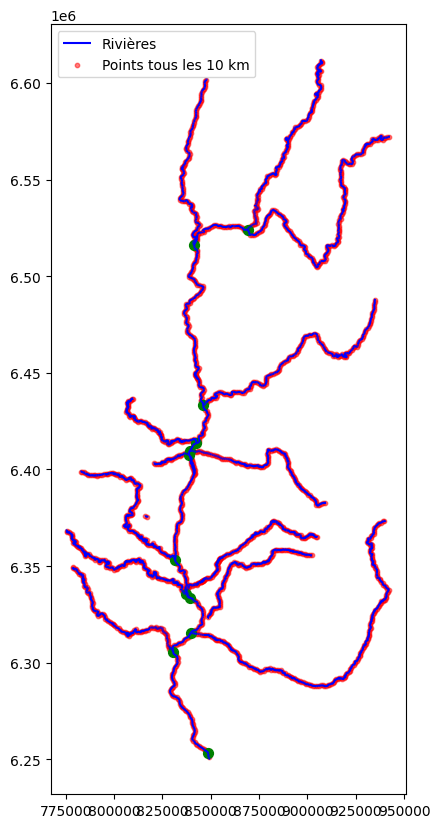

In [32]:
# Tracer les rivières fusionnées et les points
fig, ax = plt.subplots(figsize=(10, 10))
# Tracer les rivières
affluent_river_groupe.plot(ax=ax, color='blue')
# Tracer les points
point_distance.plot(ax=ax, color='red', markersize=10, alpha=0.5)
df_confluence.plot(ax=ax, color='green', markersize=50)
# Ajouter des légendes
plt.legend(["Rivières", "Points tous les 10 km"])
# Afficher le graphique
plt.show()

### Importation de l'API

In [33]:
data_site = get_site_data()
df = pd.DataFrame(data_site['data'])

point_site = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude_site, df.latitude_site), crs="EPSG:4326")
point_site = point_site.to_crs(epsg=2154)

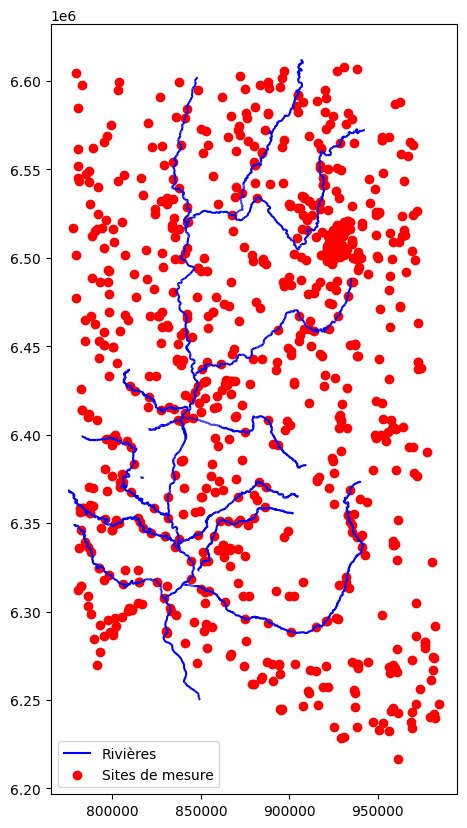

In [34]:
ax = affluent_river_groupe.plot(color='blue', figsize=(10, 10), label='Rivières')
point_site.plot(ax=ax, color='red', label='Sites de mesure')
# ajouter la legende des affluents
plt.legend()
plt.show()

In [35]:
site_filtered = find_site(affluent_river_groupe, point_site)

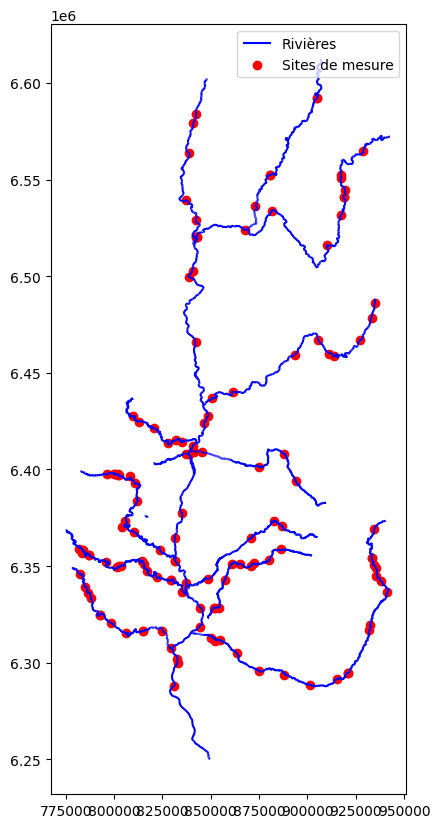

In [36]:
ax = affluent_river_groupe.plot(color='blue', figsize=(10, 10), label='Rivières')
site_filtered.plot(ax=ax, color='red', label='Sites de mesure')
# ajouter la legende des affluents
plt.legend()

In [37]:
site_filtered['distance'] = site_filtered.apply(get_nearest_distance, axis=1, points_distance=point_distance)
# Afficher les résultats avec la nouvelle colonne de distance
df_final = site_filtered[['geometry', 'river_name', 'distance', "code_site"]].reset_index(drop=True).copy()
# enregistrer en csv
df_final.to_csv('database/site_affluent_rhone.csv', index=False)

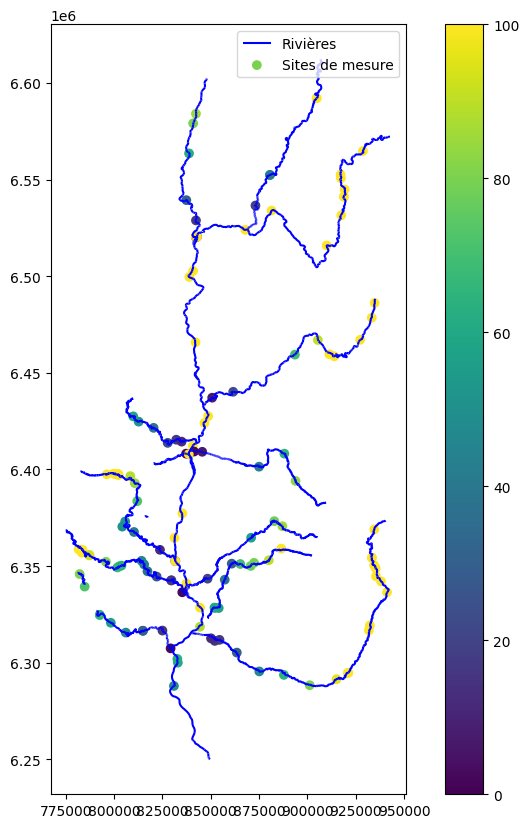

In [14]:
ax = affluent_river_groupe.plot(color='blue', figsize=(10, 10), label='Rivières')
df_final.plot(ax=ax, column="distance", cmap='viridis', legend=True, label='Sites de mesure', vmax=100)
# ajouter la legende des affluents
plt.legend()